In [18]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis
import scipy as sp
import seaborn as sns

# load

In [2]:
subject_traj_stacks = np.load("subject_raw_trajectory_stacks.npy")
subject_traj_stacks.shape

(46, 45, 12, 2, 2000)

In [3]:
def load_subject_indices(subject_idx):
    return np.load(f"index_stacks/index_stack_{subject_idx}.npy")
subject_indices = load_subject_indices(0)
subject_indices.shape

(45, 12, 2000)

# rotate

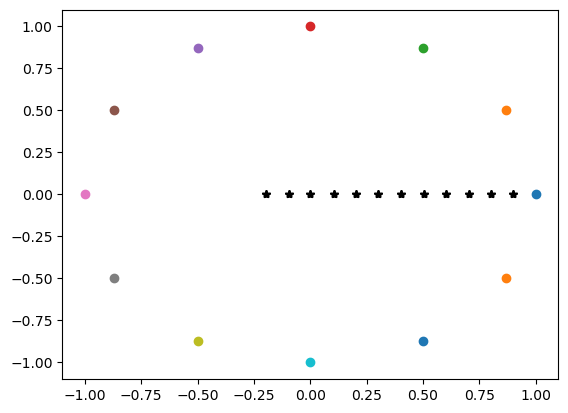

In [7]:
def make_2d_rotation_matrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T

def rotation_matrix_from_target(target):
    # "undoes" the rotation by the target angle
    # assume [x, y]
    assert target.shape == (2,), target.shape
    # the "closest" angle between the two targets
    theta = np.arctan2(target[1],target[0])
    R = make_2d_rotation_matrix(theta)
    return R

def rotate(R, vec):
    return R @ vec

def rotate_trajectory(trajectory_samples, target_number):
    R = rotation_matrix_from_target(np.array(collection.compute_target_vec_from_number(target_number)))
    assert trajectory_samples.shape[0] > trajectory_samples.shape[1]
    assert trajectory_samples.shape[1] == 2
    return rotate(R, trajectory_samples.T)

# test
for target_number in range(1,13):
    vec = np.array([collection.compute_target_vec_from_number(target_number) for _ in range(3)])
    plt.plot(vec[0,0],vec[0,1],"o")
    r_vec = rotate_trajectory(vec, target_number)
    plt.plot(r_vec[0]-0.1*target_number,r_vec[1],"k*")


# filter + rotate -- plot all targets over "chunks" of sessions

In [79]:
def chunk_indices():
    return [(i,j) for i,j in zip(range(0,45-9+1,9),range(9,46,9))]

def load_rotated_trajectories(subject_idx):
    rotated_trajectories = np.zeros_like(subject_traj_stacks[subject_idx])
    rotated_trajectories[:] = np.nan

    for session_idx in range(45):
        for target_idx in range(12):
            target_number = target_idx + 1
            # for each chunk
            trials = subject_traj_stacks[subject_idx,session_idx,target_idx]
            rotated_trajectories[session_idx,target_idx] = rotate_trajectory(trials.T,target_number)
    return rotated_trajectories


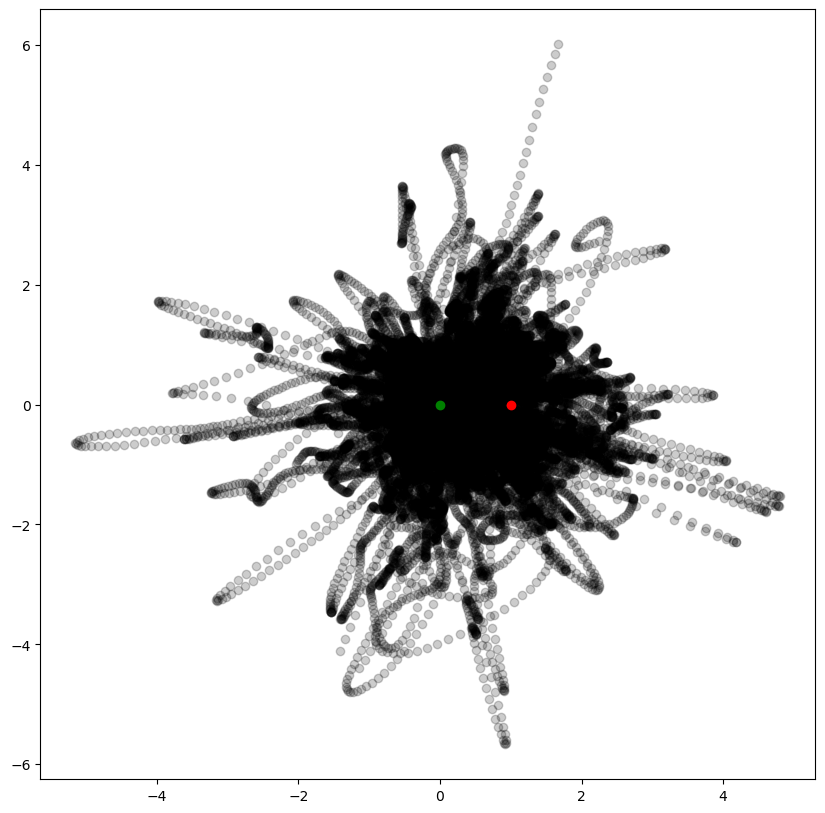

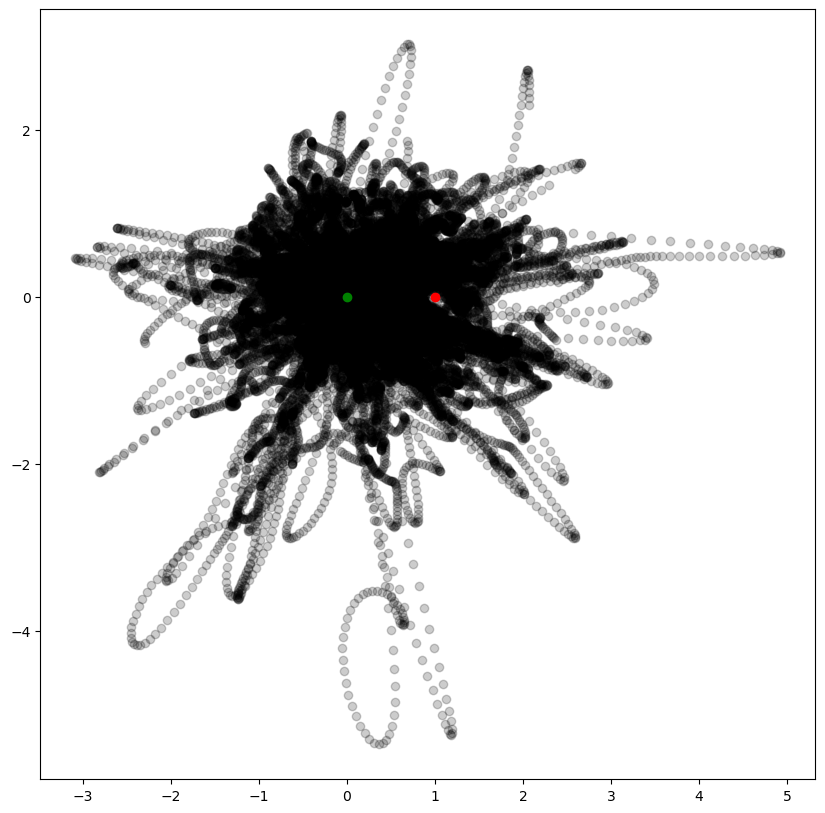

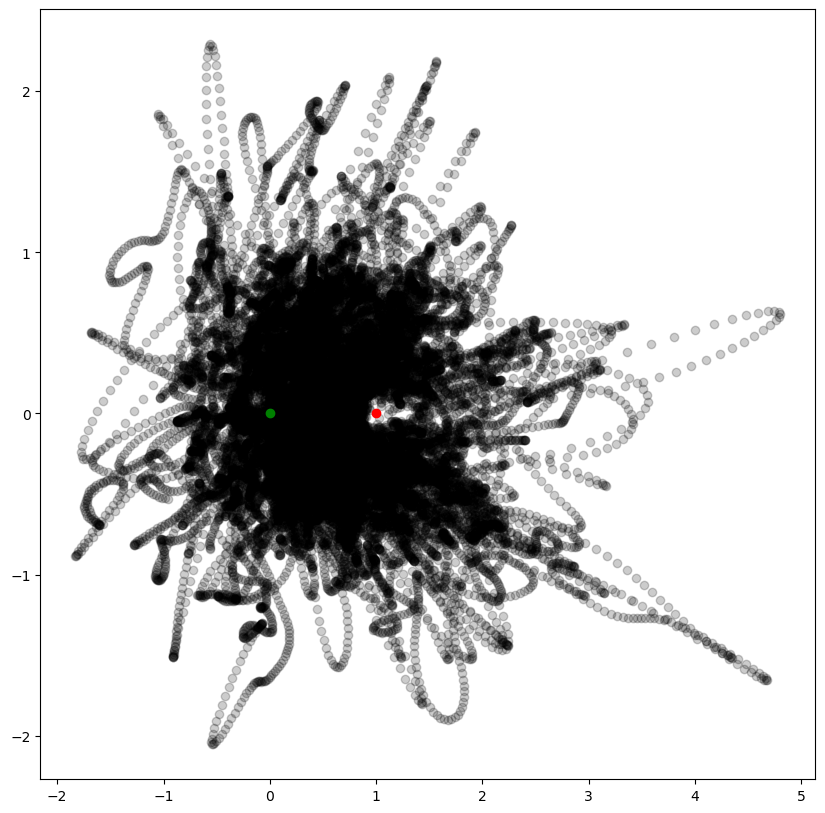

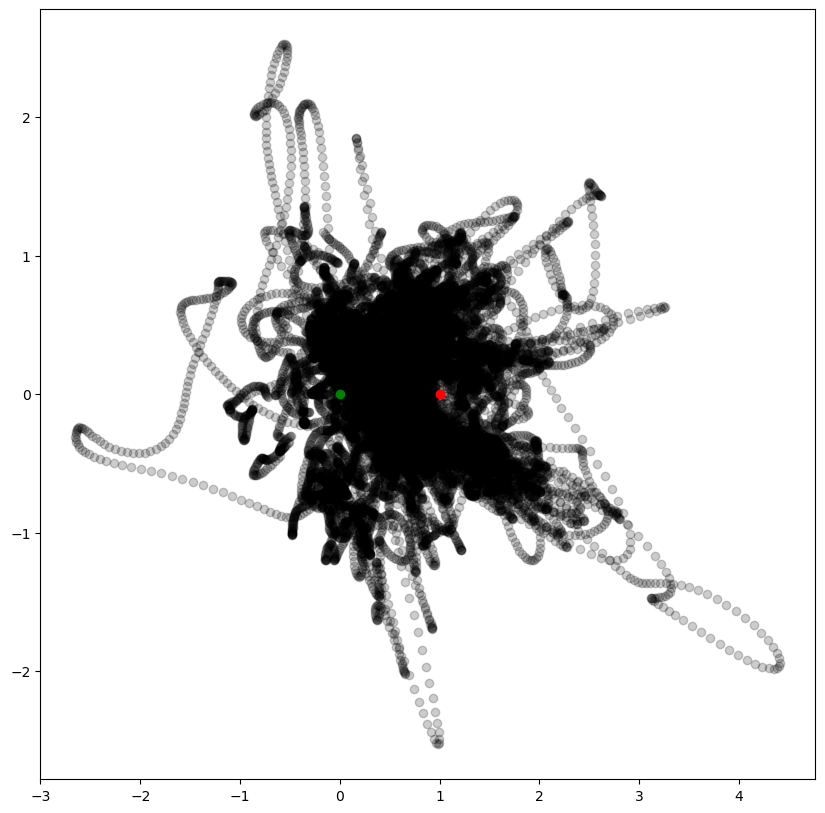

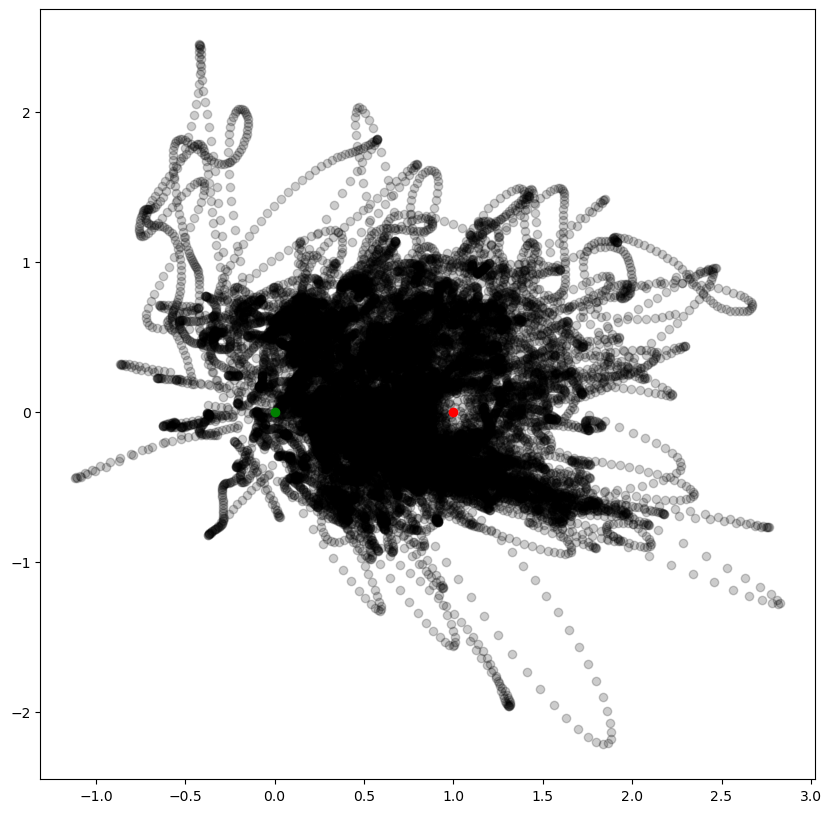

In [81]:
subject_idx = 1

rotated_trajectories = load_rotated_trajectories(subject_idx)
subject_indices = load_subject_indices(subject_idx)

# plot the chunks
for start_idx, end_idx in chunk_indices():
    fig, axes = plt.subplots(1,1,figsize=(10,10))
    for target_idx in range(12):
        target_number = target_idx + 1
        # for each chunk
        chunk_trials = subject_traj_stacks[subject_idx,start_idx:end_idx,target_idx]
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx,target_idx]
        for i, (trial, r_trial) in enumerate(zip(chunk_trials,rotated_chunk_trials)):
            # plt.plot(trial[0],trial[1],"k",alpha=0.2)
            # plt.plot(r_trial[0],r_trial[1],"r",alpha=0.2)
            idx = analysis.remove_nan_rows(subject_indices[start_idx+i,target_idx].reshape(-1,1)).astype(int)
            plt.plot(r_trial[0,idx],r_trial[1,idx],"ko",alpha=0.2)
    plt.plot(0,0,"go")
    plt.plot(1,0,"ro")

# histograms

In [106]:
chunk_indices = list(zip(np.arange(45),np.arange(1,46)))

/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

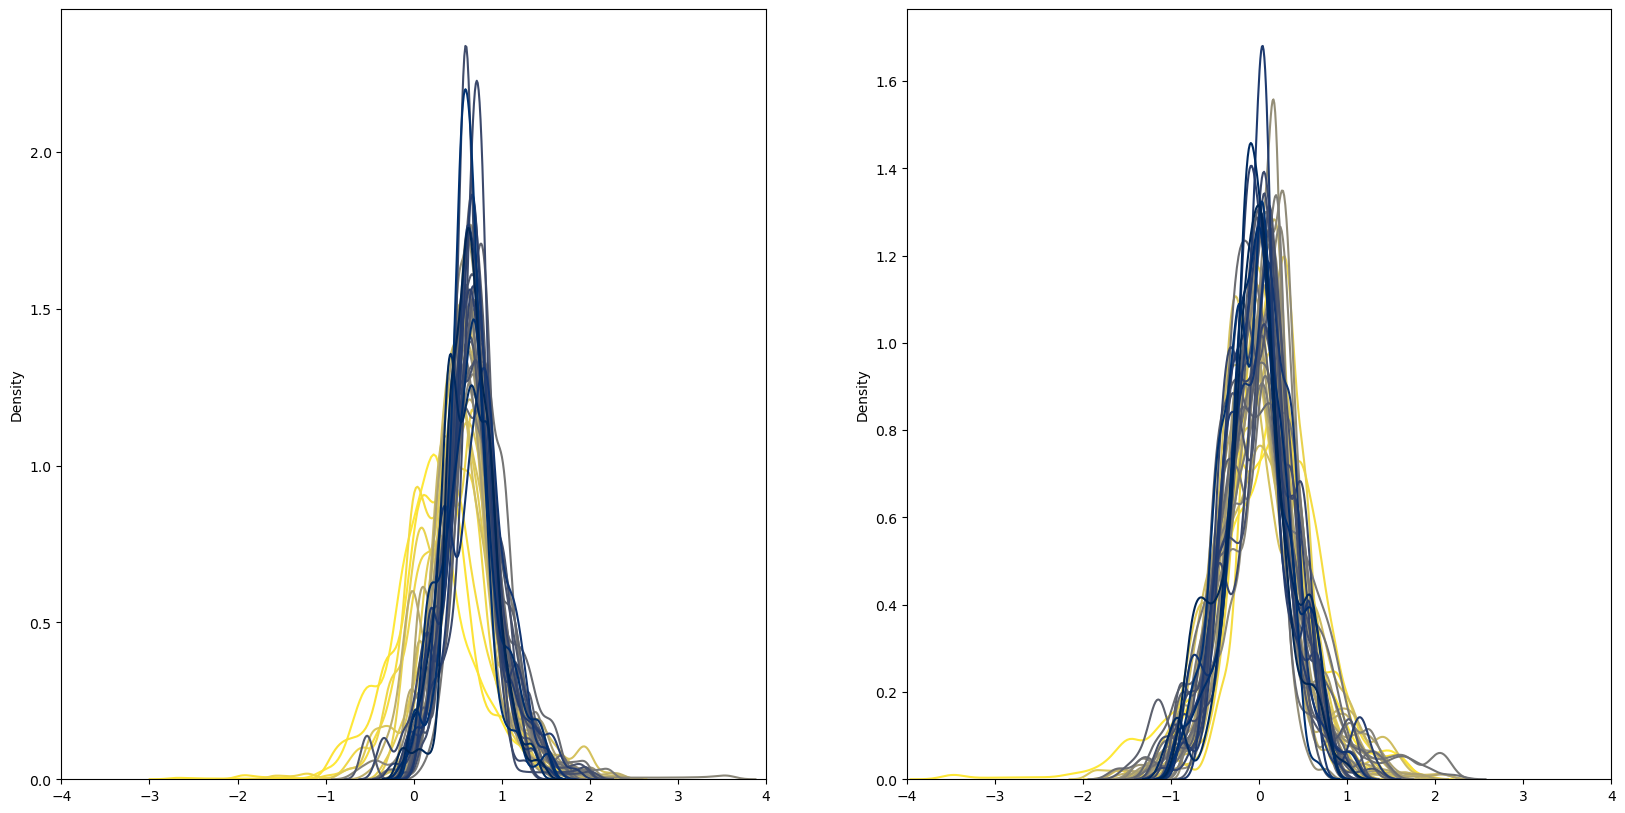

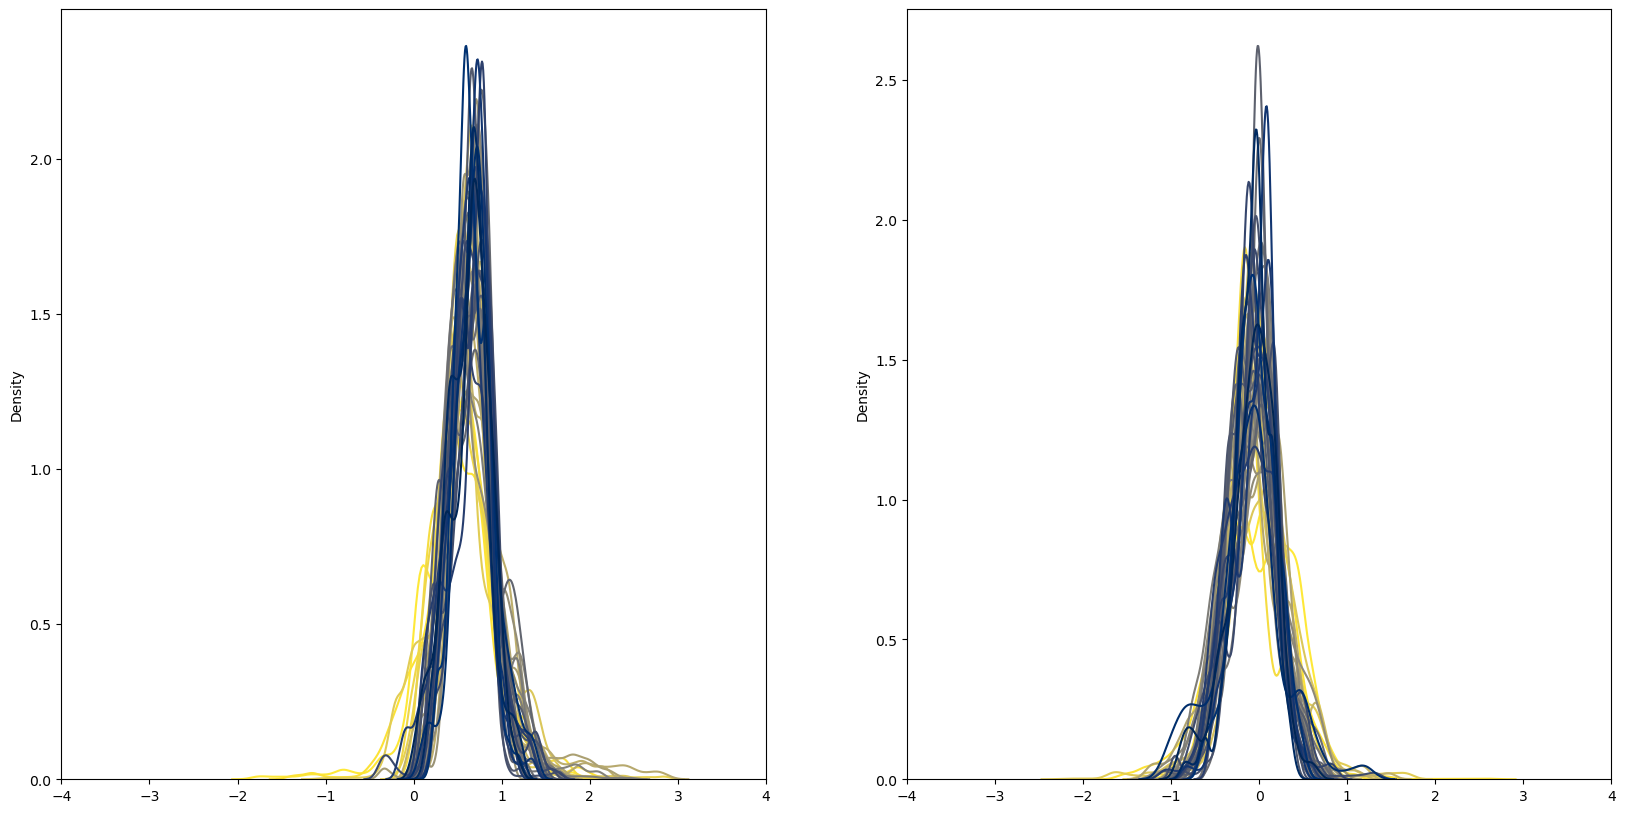

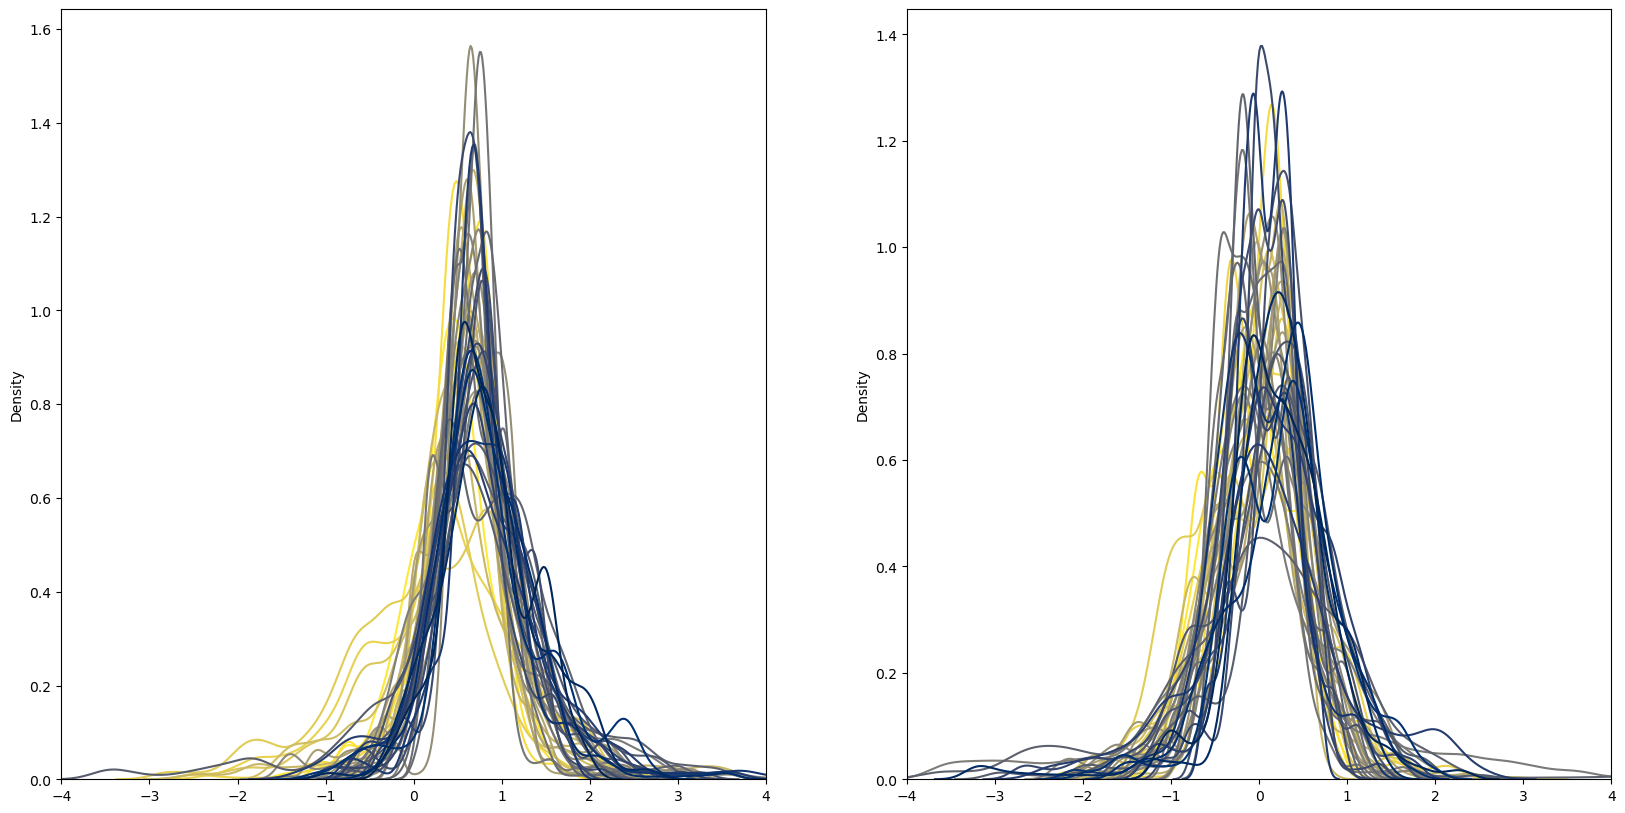

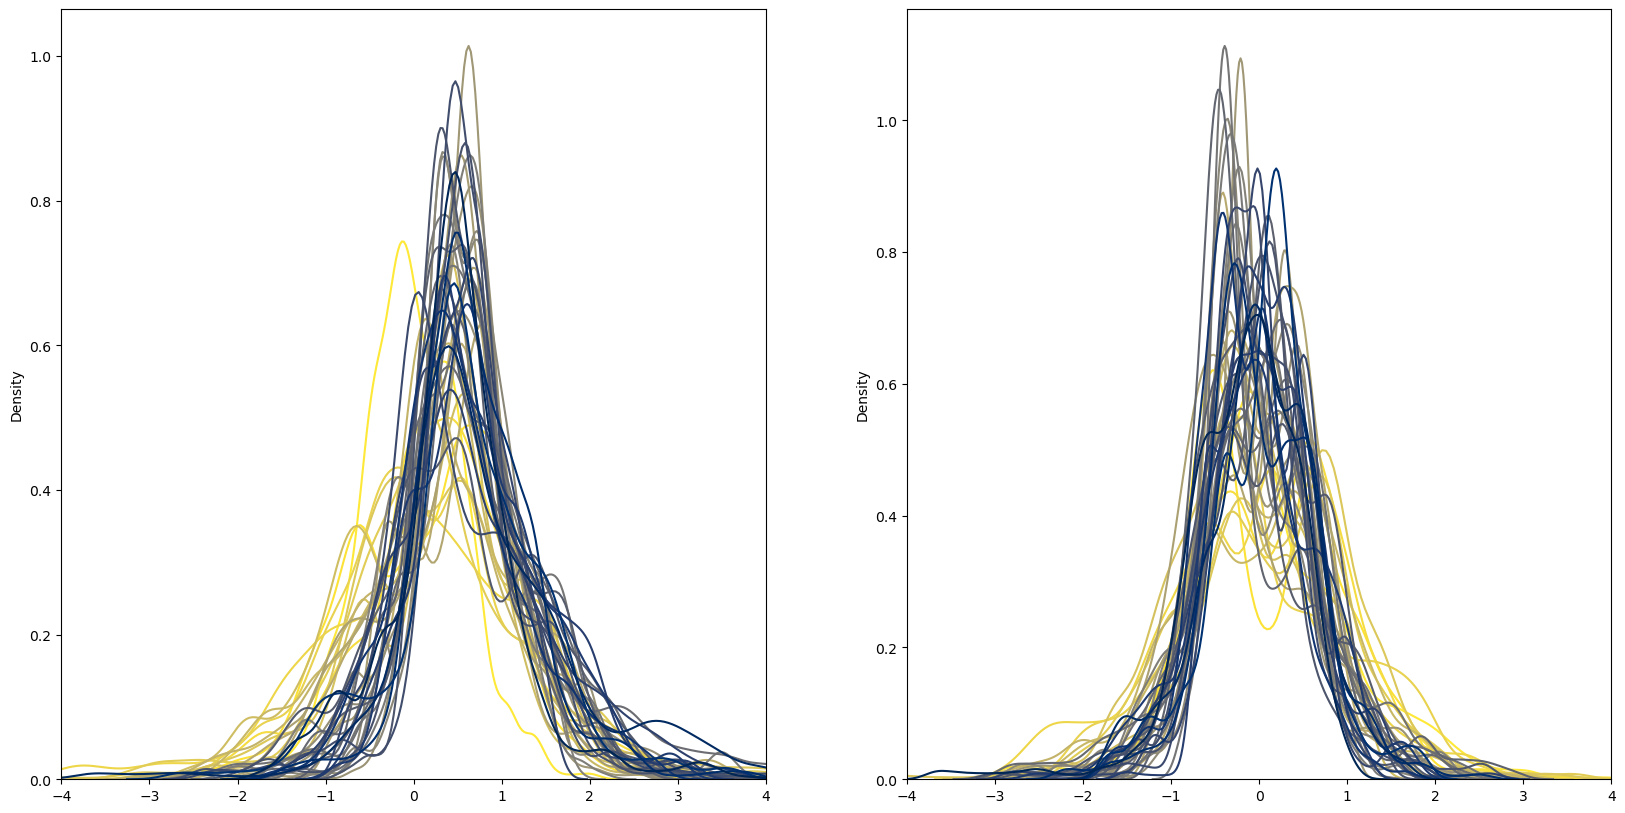

In [107]:
subject_vars = []
subjects_to_plot = [6,29,35,9]
for subject_idx in subjects_to_plot:
    fig, axes = plt.subplots(1,2,figsize=(20,10))
    for ax in axes:
        ax.set_xlim([-4,4])

    rotated_trajectories = load_rotated_trajectories(subject_idx)
    subject_indices = load_subject_indices(subject_idx)

    vars = []
    for i, (start_idx, end_idx) in enumerate(chunk_indices):
        
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx].transpose(0,1,3,2)
        chunk_trial_idxs = subject_indices[start_idx:end_idx]
        
        rotated_chunk_trials = rotated_chunk_trials.reshape(-1,2000,2)
        chunk_trial_idxs = chunk_trial_idxs.reshape(-1,2000)

        trial_to_plot = np.empty(shape=(0,2))
        for trial, trial_idx in zip(rotated_chunk_trials, chunk_trial_idxs):
            idxs = analysis.remove_nan_rows(trial_idx.reshape(-1,1)).reshape(-1).astype(int)
            trial_to_plot = np.append(trial_to_plot,trial[idxs,:],axis=0)
        trial_to_plot = analysis.remove_nan_rows(trial_to_plot)
        vars.append(np.var(trial_to_plot,axis=0))

        sns.kdeplot(trial_to_plot[:,0],color=colormaps["cividis"](1 - i/len(chunk_indices)),ax=axes[0])
        sns.kdeplot(trial_to_plot[:,1],color=colormaps["cividis"](1 - i/len(chunk_indices)),ax=axes[1])
        
    subject_vars.append(vars)

In [117]:
subject_vars = []
subjects_to_plot = [6,29,35,9]
for subject_idx in range(46):

    rotated_trajectories = load_rotated_trajectories(subject_idx)
    subject_indices = load_subject_indices(subject_idx)

    vars = []
    for i, (start_idx, end_idx) in enumerate(chunk_indices):
        
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx].transpose(0,1,3,2)
        chunk_trial_idxs = subject_indices[start_idx:end_idx]
        
        rotated_chunk_trials = rotated_chunk_trials.reshape(-1,2000,2)
        chunk_trial_idxs = chunk_trial_idxs.reshape(-1,2000)

        trial_to_plot = np.empty(shape=(0,2))
        for trial, trial_idx in zip(rotated_chunk_trials, chunk_trial_idxs):
            idxs = analysis.remove_nan_rows(trial_idx.reshape(-1,1)).reshape(-1).astype(int)
            trial_to_plot = np.append(trial_to_plot,trial[idxs,:],axis=0)
        trial_to_plot = analysis.remove_nan_rows(trial_to_plot)
        vars.append(np.var(trial_to_plot,axis=0))
    subject_vars.append(vars)

(4645, 2)
(3099, 2)
(2646, 2)
(4151, 2)
(3571, 2)
(4206, 2)
(2655, 2)
(3565, 2)
(4485, 2)
(3752, 2)
(2381, 2)
(3014, 2)
(1908, 2)
(2736, 2)
(3052, 2)
(2062, 2)
(3727, 2)
(4242, 2)
(5361, 2)
(4272, 2)
(5254, 2)
(3781, 2)
(3238, 2)
(3215, 2)
(3577, 2)
(3087, 2)
(3250, 2)
(2326, 2)
(3135, 2)
(2980, 2)
(2374, 2)
(1984, 2)
(2300, 2)
(2451, 2)
(2493, 2)
(1946, 2)
(2381, 2)
(2320, 2)
(2865, 2)
(2639, 2)
(3165, 2)
(1511, 2)
(2729, 2)
(3911, 2)
(3818, 2)
(4609, 2)
(4869, 2)
(4319, 2)
(5152, 2)
(5364, 2)
(5714, 2)
(5254, 2)
(5618, 2)
(5027, 2)
(4568, 2)
(5090, 2)
(4385, 2)
(5241, 2)
(4620, 2)
(4899, 2)
(4988, 2)
(4804, 2)
(4736, 2)
(4531, 2)
(4077, 2)
(4054, 2)
(4231, 2)
(3870, 2)
(3710, 2)
(3600, 2)
(4267, 2)
(4146, 2)
(4469, 2)
(3463, 2)
(4296, 2)
(2804, 2)
(3570, 2)
(3371, 2)
(2437, 2)
(3318, 2)
(3109, 2)
(3221, 2)
(3312, 2)
(2963, 2)
(3316, 2)
(2853, 2)
(2427, 2)
(3697, 2)
(2355, 2)
(2360, 2)
(5528, 2)
(5210, 2)
(4623, 2)
(6556, 2)
(5959, 2)
(6978, 2)
(5896, 2)
(5059, 2)
(5417, 2)
(5991, 2)


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(7166, 2)
(6394, 2)
(7410, 2)
(5251, 2)
(5716, 2)
(5995, 2)
(5465, 2)
(4933, 2)
(4470, 2)
(4698, 2)
(3819, 2)
(4050, 2)
(4310, 2)
(4065, 2)
(5587, 2)
(5496, 2)
(4065, 2)
(3611, 2)
(4192, 2)
(3564, 2)
(4486, 2)
(3582, 2)
(3941, 2)
(4841, 2)
(4235, 2)
(2930, 2)
(4081, 2)
(3478, 2)
(3866, 2)
(4273, 2)
(2700, 2)
(3740, 2)
(4183, 2)
(3017, 2)
(3613, 2)
(3499, 2)
(4117, 2)
(2691, 2)
(3131, 2)
(3538, 2)
(2414, 2)
(2510, 2)
(4638, 2)
(4077, 2)
(3749, 2)
(5127, 2)
(5478, 2)
(4883, 2)
(5405, 2)
(5682, 2)
(4793, 2)
(4508, 2)
(4825, 2)
(5090, 2)
(6054, 2)
(5721, 2)
(5130, 2)
(4694, 2)
(5957, 2)
(6066, 2)
(6045, 2)
(5729, 2)
(5410, 2)
(6001, 2)
(5501, 2)
(5588, 2)
(6045, 2)
(5722, 2)
(5749, 2)
(6119, 2)
(5492, 2)
(5373, 2)
(5316, 2)
(4514, 2)
(5777, 2)
(5377, 2)
(5480, 2)
(5565, 2)
(5633, 2)
(5595, 2)
(5503, 2)
(5930, 2)
(5888, 2)
(4212, 2)
(5608, 2)
(5899, 2)
(5202, 2)
(5305, 2)
(4953, 2)
(6211, 2)
(5589, 2)
(5837, 2)
(5183, 2)
(5087, 2)
(5495, 2)
(5442, 2)
(5212, 2)
(5598, 2)
(5515, 2)
(6040, 2)


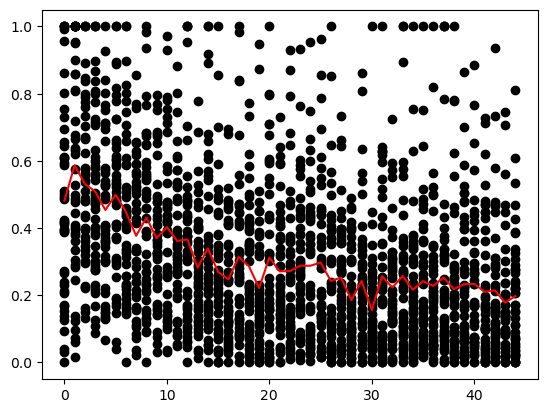

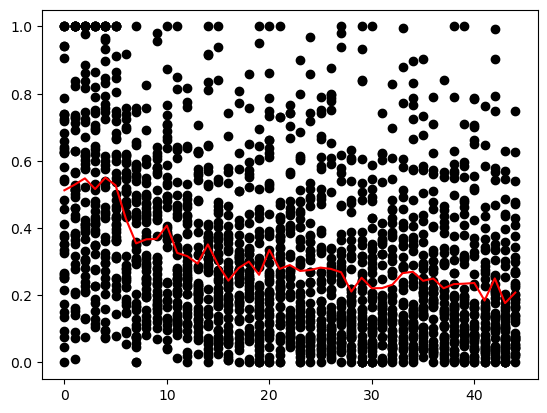

In [118]:
ns = []
for v in np.array(subject_vars)[:,:,0]:
    diff = v - np.min(v)
    n = diff / np.max(diff)
    ns.append(n)
    plt.plot(diff / np.max(diff),"ko")
plt.plot(np.nanmean(ns,axis=0),"r")

plt.figure()
ns = []
for v in np.array(subject_vars)[:,:,1]:
    diff = v - np.min(v)
    n = diff / np.max(diff)
    ns.append(n)
    plt.plot(diff / np.max(diff),"ko")
plt.plot(np.nanmean(ns,axis=0),"r")



# plot

### show trajectory variance decreasing over time for each target

/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

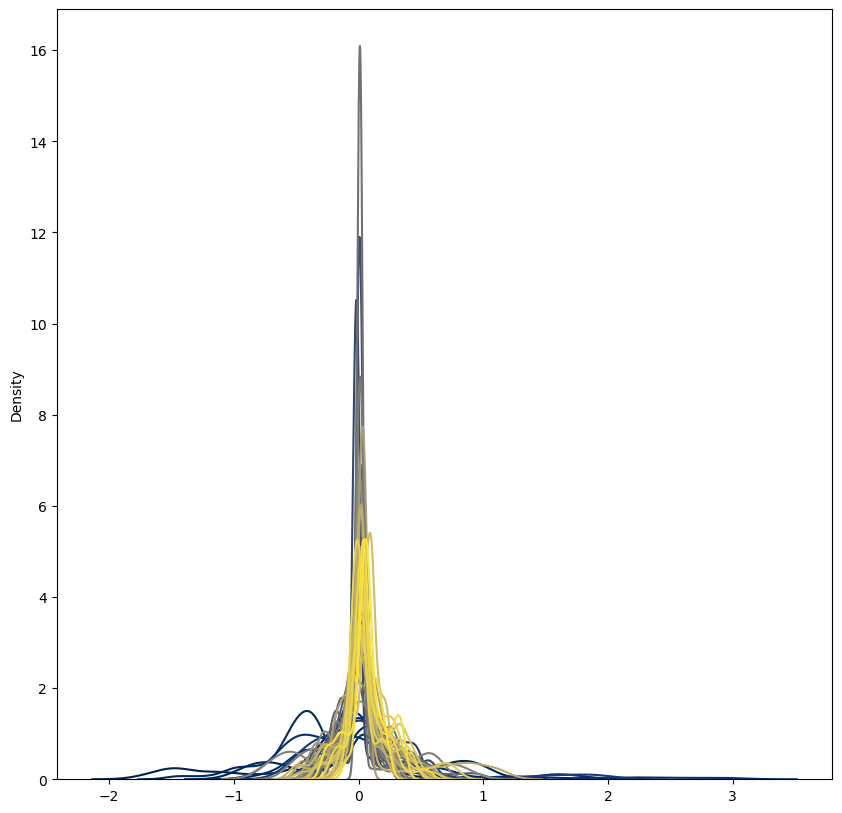

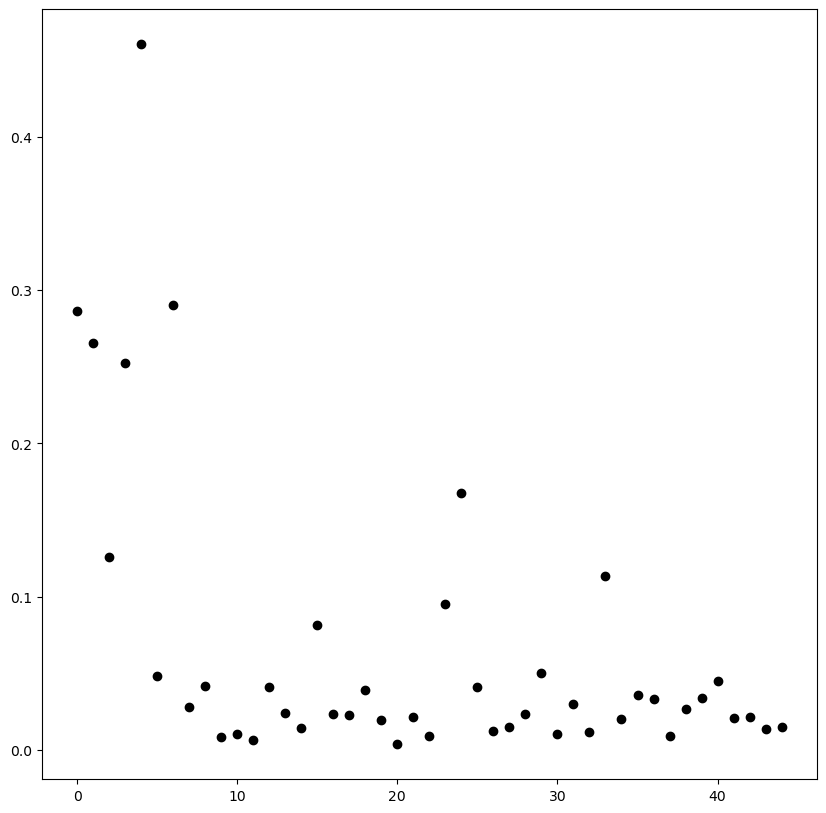

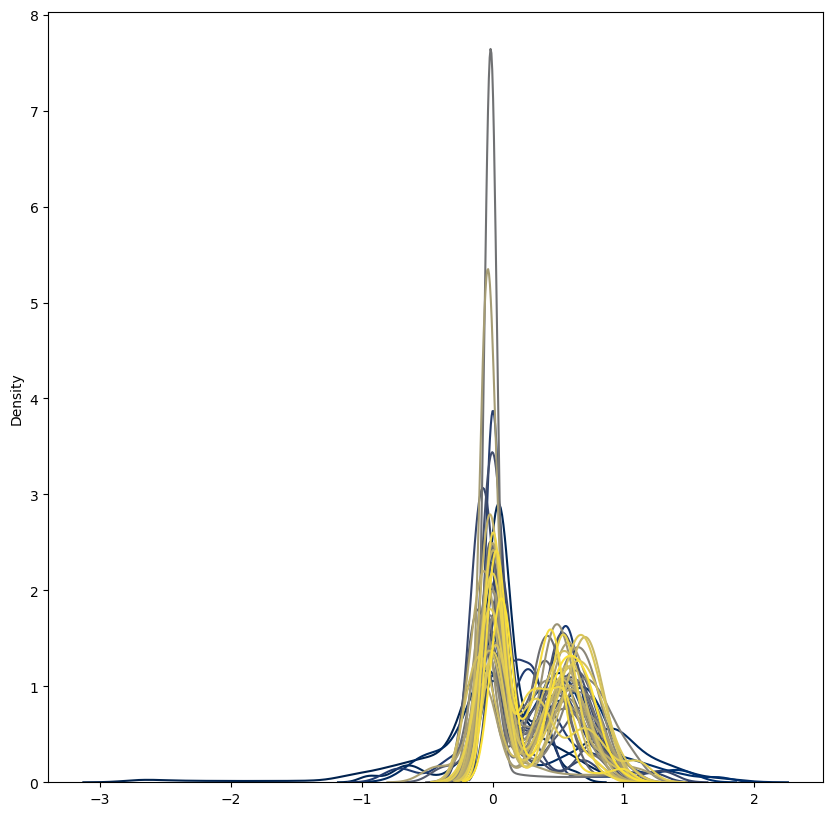

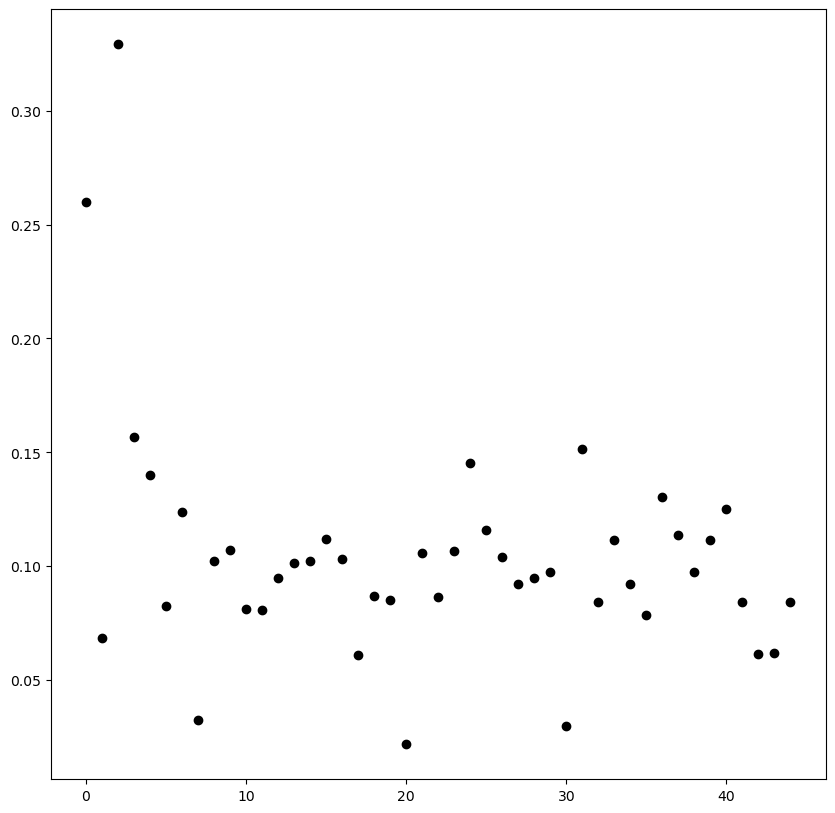

In [5]:
fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,0],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,0]),"ko")

fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,1],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,1]),"ko")

/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

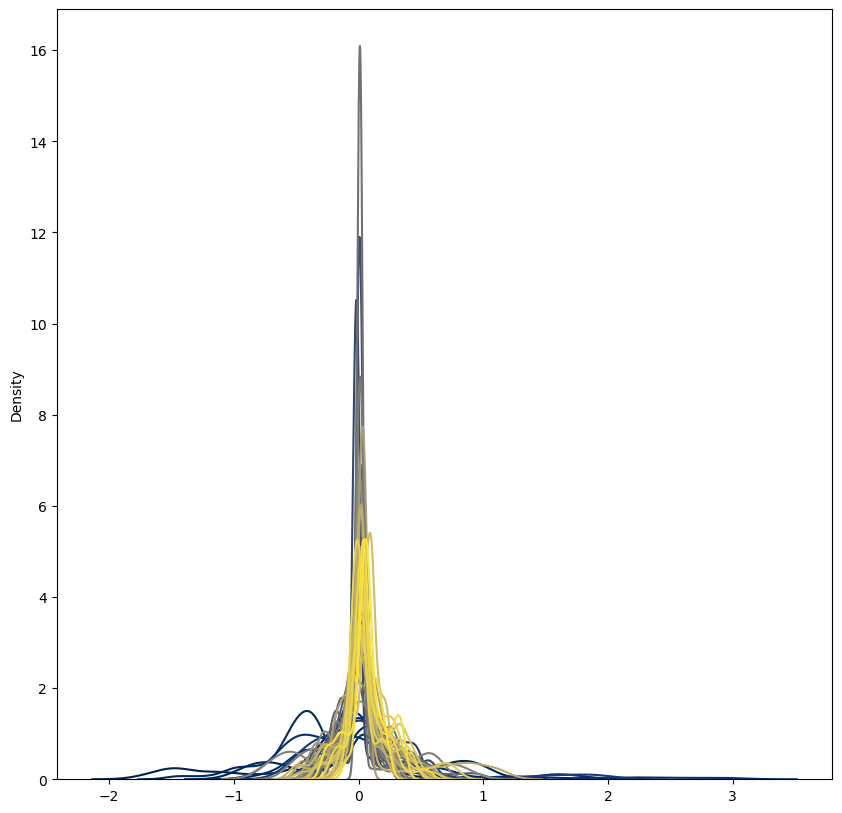

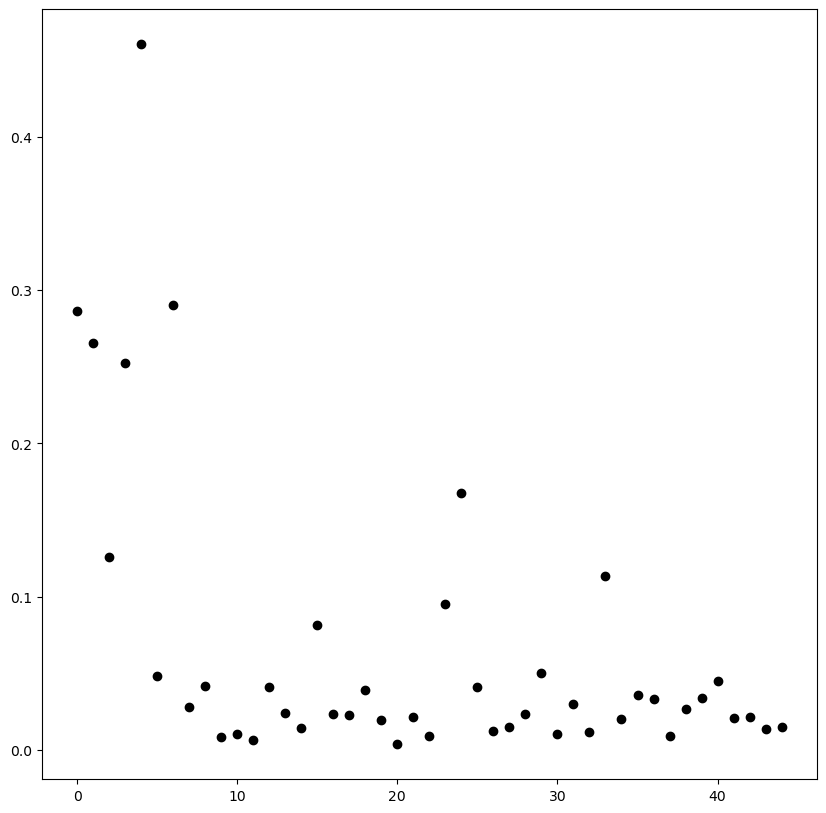

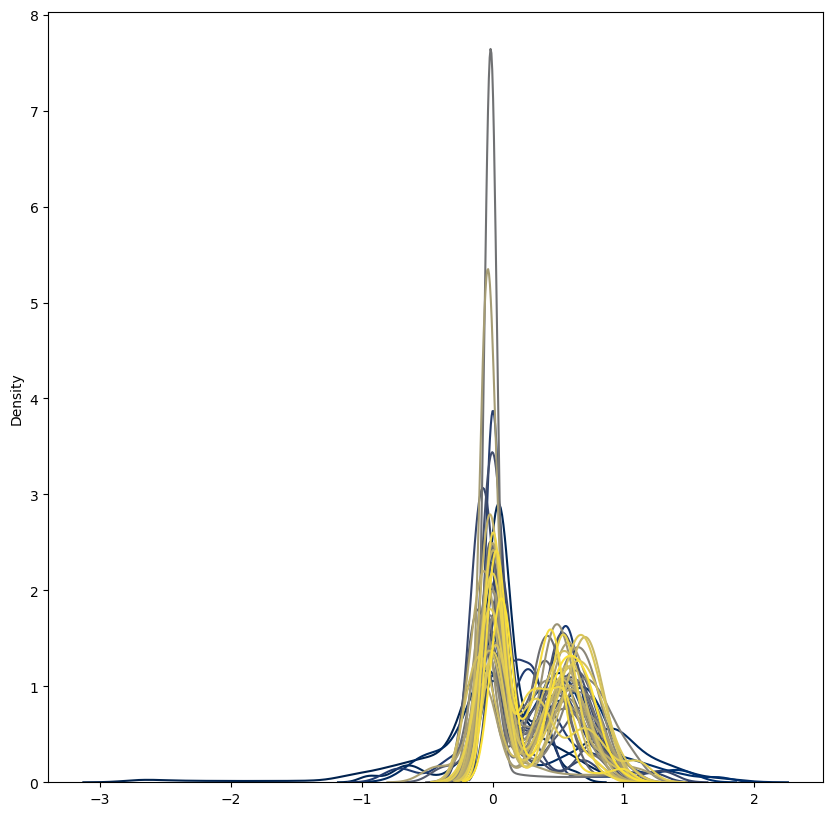

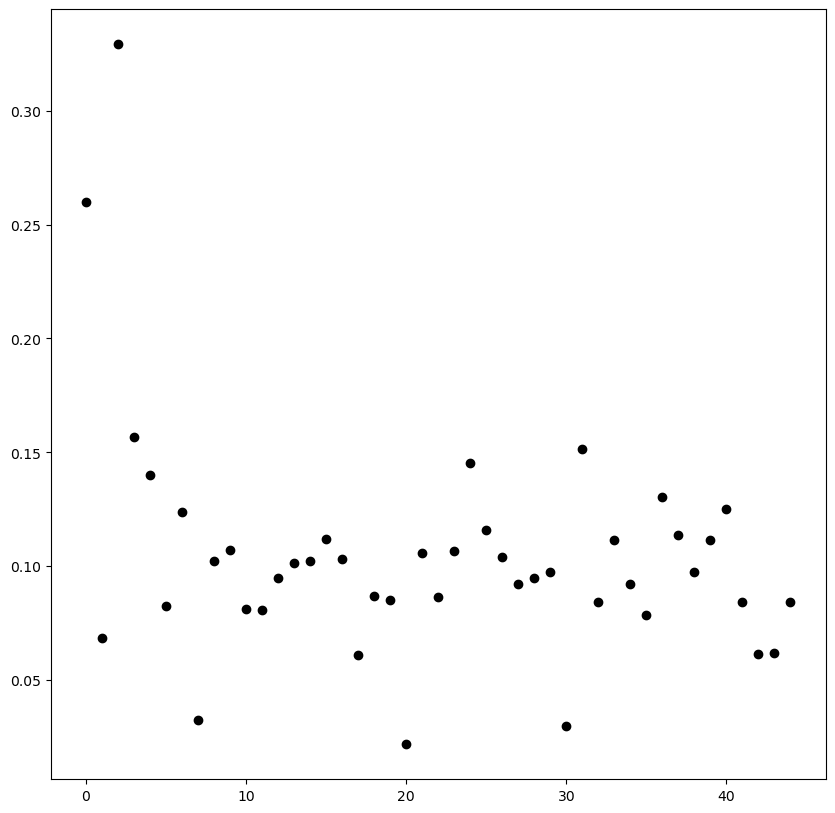

In [ ]:
fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,0],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,0]),"ko")

fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,1],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,1]),"ko")

In [ ]:
c = collection.Collection("emg_olympics")
subject_number = 1
s = c.subjects[c.subject_names[subject_number]]
trials = []
for sesh in s.tasks["center_hold"].sorted_sessions():
    trials.extend(sesh.sorted_trials())
target_number = 12

first_hit_trial = None
last_hit_trial = None
for t in trials:
    if t.target_number == target_number and t.outcome == "Hit":
        first_hit_trial = t
# print(first_hit_trial.session_name, first_hit_trial.number)

for t in trials[::-1]:
    if t.target_number == target_number and t.outcome == "Hit":
        last_hit_trial = t
# print(last_hit_trial.session_name, last_hit_trial.number)

first_traj = first_hit_trial.get_trajectory()
last_traj = last_hit_trial.get_trajectory()
first_emg = first_hit_trial.get_filtered_emg()
last_emg = last_hit_trial.get_filtered_emg()
plt.plot(first_traj[:,-2],first_traj[:,-1])
plt.plot(last_traj[:,-2],last_traj[:,-1])
analysis.plot_targets(plt.gca())
plt.xlim([-2,2])
plt.ylim([-2,2])

plt.figure()
plt.plot(first_traj[:,-2])
plt.plot(last_traj[:,-2])

plt.figure()
plt.plot(first_traj[:,-1])
plt.plot(last_traj[:,-1])